- [数据集来源](https://ai.stanford.edu/~amaas/data/sentiment/)
## Large Movie Review Dataset
- This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. See the README file contained in the release for more details.

In [6]:
import os
import torch

from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext import transforms as T
from torch.utils.data import TensorDataset

def read_data(path='./aclImdb', is_train=True):
    reviews, labels = [], []
    tokenizer = get_tokenizer('basic_english')
    for label in ['pos', 'neg']:
        folder_name = os.path.join(path, 'train' if is_train else 'test', label)
        for filename in os.listdir(folder_name):
            with open(os.path.join(folder_name, filename), mode='r', encoding='utf-8') as f:
                reviews.append(tokenizer(f.read()))
                labels.append(1 if label == 'pos' else 0)
    return reviews, labels


def build_dataset(reviews, labels, vocab, max_len=512):
    text_transform = T.Sequential(
        T.VocabTransform(vocab=vocab),
        T.Truncate(max_seq_len=max_len),
        T.ToTensor(padding_value=vocab['<pad>']),
        T.PadTransform(max_length=max_len, pad_value=vocab['<pad>']),
    )
    dataset = TensorDataset(text_transform(reviews), torch.tensor(labels))
    return dataset


def load_data():
    reviews_train, labels_train = read_data(is_train=True)
    reviews_test, labels_test = read_data(is_train=False)
    vocab = build_vocab_from_iterator(reviews_train, min_freq=3, specials=['<pad>', '<unk>', '<cls>', '<sep>'])
    vocab.set_default_index(vocab['<unk>'])
    train_data = build_dataset(reviews_train, labels_train, vocab)
    test_data = build_dataset(reviews_test, labels_test, vocab)
    return train_data, test_data, vocab

train_data, test_data, vocab = load_data()
vocab_size = len(vocab)
print(vocab_size)

40254


### 2. 定义TextCNN模型类

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, kernel_sizes=(3, 4, 5), num_channels=100):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_channels, (k, embed_dim)) for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(num_channels * len(kernel_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        x = x.unsqueeze(1)  # [batch_size, 1, seq_len, embed_dim]
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]  # List of [batch_size, num_channels, *]
        x = [F.max_pool1d(item, item.size(2)).squeeze(2) for item in x]  # List of [batch_size, num_channels]
        x = torch.cat(x, 1)  # [batch_size, num_channels * len(kernel_sizes)]
        x = self.dropout(x)
        x = self.fc(x)
        return x


### 3. 训练和测试函数：

In [8]:
def train_model(model, train_data, criterion, optimizer, device, num_epochs=10, batch_size=64):
    model.to(device)
    model.train()
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    return train_losses, train_accuracies


def evaluate_model(model, test_data, device, batch_size=64):
    model.to(device)
    model.eval()
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy




### 绘制曲线

In [10]:

import matplotlib.pyplot as plt
def plot_metrics(train_losses, train_accuracies, test_accuracy):
    epochs = range(1, len(train_losses) + 1)
    
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, train_losses, 'r-', label='Train Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()
    plt.title(f'Test Accuracy: {test_accuracy:.2f}%')
    plt.show()

### 3. 组合 

Using device: cuda
Epoch [1/10], Loss: 0.6240, Accuracy: 66.05%
Epoch [2/10], Loss: 0.4737, Accuracy: 77.26%
Epoch [3/10], Loss: 0.3936, Accuracy: 82.45%
Epoch [4/10], Loss: 0.3264, Accuracy: 85.82%
Epoch [5/10], Loss: 0.2647, Accuracy: 88.90%
Epoch [6/10], Loss: 0.2036, Accuracy: 91.78%
Epoch [7/10], Loss: 0.1481, Accuracy: 94.36%
Epoch [8/10], Loss: 0.1064, Accuracy: 96.12%
Epoch [9/10], Loss: 0.0712, Accuracy: 97.34%
Epoch [10/10], Loss: 0.0544, Accuracy: 98.10%
Test Accuracy: 86.46%


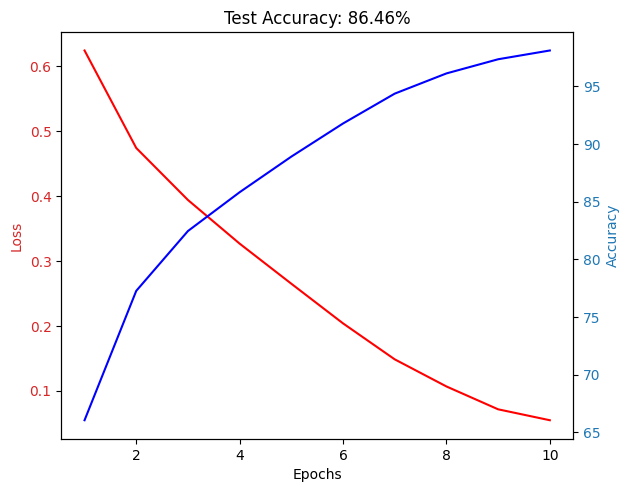

In [11]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


embed_dim = 128
num_classes = 2

model = TextCNN(vocab_size, embed_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, train_accuracies = train_model(model, train_data, criterion, optimizer, device, num_epochs=10)
test_accuracy = evaluate_model(model, test_data, device)

plot_metrics(train_losses, train_accuracies, test_accuracy)



In [12]:
# 实现单个句子的预测函数
def predict_sentences(model, vocab, sentences, device, max_len=512):
    tokenizer = get_tokenizer('basic_english')
    text_transform = T.Sequential(
        T.VocabTransform(vocab=vocab),
        T.Truncate(max_seq_len=max_len),
        T.ToTensor(padding_value=vocab['<pad>']),
        T.PadTransform(max_length=max_len, pad_value=vocab['<pad>']),
    )
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        for sentence in sentences:
            tokens = tokenizer(sentence)
            tensor = text_transform([tokens]).to(device)
            output = model(tensor)
            _, predicted = torch.max(output.data, 1)
            label = 'Positive' if predicted.item() == 1 else 'Negative'
            print(f'Sentence: {sentence}\nPredicted Sentiment: {label}\n')
            

# 示例句子进行预测
example_sentences = [
    "This movie was fantastic! I really enjoyed the storyline and the acting was superb.",
    "I hated this movie. It was boring and a complete waste of time.",
    "The film was okay, but it didn't live up to the hype.",
    "Amazing direction and a brilliant cast made this a movie worth watching.",
    "The plot was predictable and the characters were one-dimensional.",
    "I was on the edge of my seat the entire time. What a thriller!",
    "Terrible movie. The script was poorly written and the acting was subpar.",
    "A very touching and heartfelt story. It moved me to tears.",
    "The special effects were mind-blowing, but the story lacked depth.",
    "It was an average movie, not great but not terrible either.",
    "This movie was fantastic! I really enjoyed it.",
    "Absolutely terrible. It was a waste of time.",
    "The plot was very intriguing and the characters were well-developed.",
    "I wouldn't recommend this film to anyone. It was boring.",
    "An outstanding performance by the lead actor.",
    "The script was poorly written and the acting was subpar.",
    "A great movie with a lot of emotional depth.",
    "I fell asleep halfway through. Not engaging at all.",
    "One of the best movies I have seen this year.",
    "The cinematography was beautiful, but the story was lacking."
]


# 预测并展示结果
predict_sentences(model, vocab, example_sentences, device)

Sentence: This movie was fantastic! I really enjoyed the storyline and the acting was superb.
Predicted Sentiment: Positive

Sentence: I hated this movie. It was boring and a complete waste of time.
Predicted Sentiment: Negative

Sentence: The film was okay, but it didn't live up to the hype.
Predicted Sentiment: Negative

Sentence: Amazing direction and a brilliant cast made this a movie worth watching.
Predicted Sentiment: Positive

Sentence: The plot was predictable and the characters were one-dimensional.
Predicted Sentiment: Negative

Sentence: I was on the edge of my seat the entire time. What a thriller!
Predicted Sentiment: Positive

Sentence: Terrible movie. The script was poorly written and the acting was subpar.
Predicted Sentiment: Negative

Sentence: A very touching and heartfelt story. It moved me to tears.
Predicted Sentiment: Positive

Sentence: The special effects were mind-blowing, but the story lacked depth.
Predicted Sentiment: Negative

Sentence: It was an average 